In [33]:
import pandas as pd
import numpy as np
import timeit

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20.0, 10.0)
from matplotlib import colors

import scipy.stats

%matplotlib inline

In [34]:
import plot
import calculate

In [35]:
CAREER_LENGTH = 1 #this defines the criterion which we use to filter authors
END_YEAR = 2016
MAX_CAREER_LENGTH_COHORT = 15    # this defines how long we follow each cohort


In [36]:
# Publication data
authorPublicationData = pd.read_csv('derived-data/author-publications-atleast-5-year.csv')
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count()

print("authorPublicationData no duplicates: ", authorPublicationData.shape[0])

#print(authorPublicationData.head())


authorPublicationData no duplicates:  7275378


In [37]:
credible_authors = pd.read_csv('derived-data/authors-scientific-atleast-'+ str(CAREER_LENGTH) + '-year-extended.csv', encoding='utf-8')

In [38]:
credible_authors = credible_authors.set_index('start_year')

print("credible_authors: ", credible_authors.shape[0])
print(credible_authors.head())

#print(credible_authors[credible_authors['author'] == 'donatella sciuto'])
credible_authors.rename(columns={'num_pub':'total_num_pub'}, inplace=True)



credible_authors:  836699
                           author  end_year  num_pub  career_length  \
start_year                                                            
2009        (max) zong-ming cheng      2011        2              3   
2011             (zhou) bryan bai      2012        2              2   
1979                   a min tjoa      2017      191             39   
1986                a-chuan hsueh      1988        2              3   
2015              a-hadi n. ahmed      2015        2              1   

            early_career_qual  early_career_recognition  succ_after_15y  \
start_year                                                                
2009                      4.0                       4.0             4.0   
2011                      0.0                       0.0             0.0   
1979                      0.0                       0.0             2.0   
1986                     21.0                       9.0            21.0   
2015                      

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


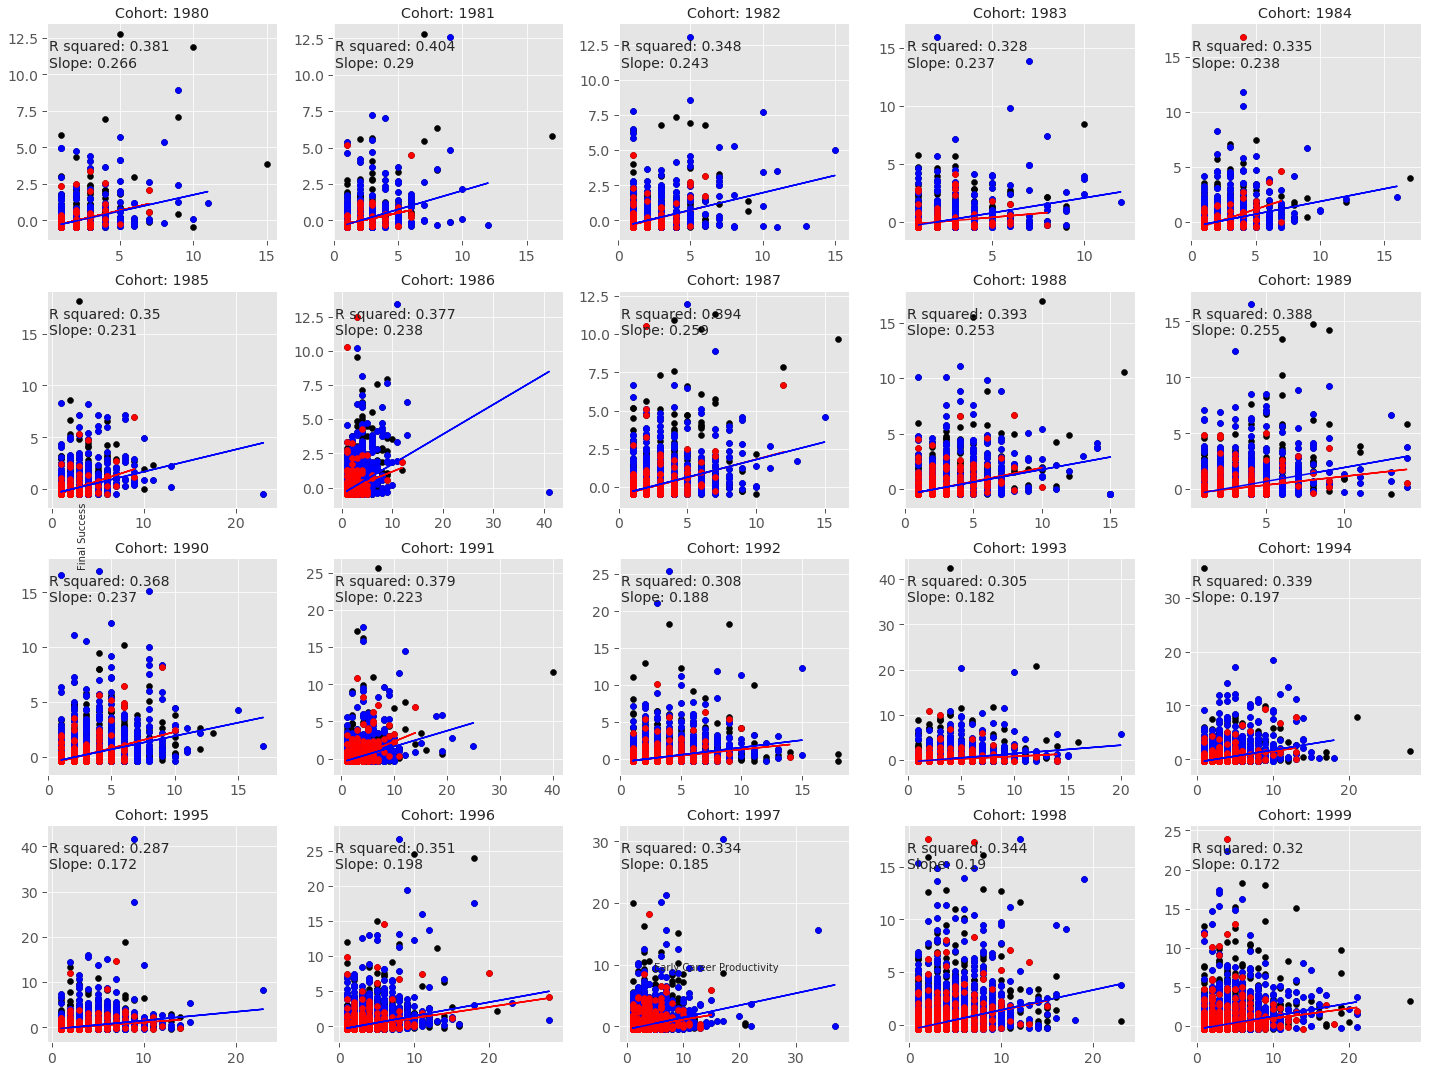

   year num_obs  group     slope  intercept   r_value       p_value   std_err
0  1980    1191    all  0.266130  -0.549020  0.380942  1.995131e-42  0.018733
1  1980     700    men  0.224422  -0.492485  0.363733  2.545775e-23  0.021754
2  1980      92  women  0.232448  -0.485186  0.375356  2.270697e-04  0.060504
3  1981    1305    all  0.290055  -0.599003  0.404460  1.558603e-52  0.018170
4  1981     738    men  0.258454  -0.533874  0.374258  5.945793e-26  0.023605


In [39]:
from matplotlib.lines import Line2D

zscore = True
numcols = 5
start_range = 1980
end_range = 2000
cells = end_range - start_range
numrows = int(cells/numcols)

var = "prod" # can also be qual

results = pd.DataFrame(columns=["year", "num_obs", "group", "slope", "intercept", "r_value", "p_value", "std_err"])
fig, ax = plt.subplots(nrows=numrows, ncols=numcols, sharex=False, sharey=False, figsize=(20,15))


custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='black', lw=4)]
for year in range(start_range, end_range):
    data = credible_authors.loc[year]
    x = data['early_career_prod']
    
    
    if(zscore):
        y = (data['succ_after_15y']-np.mean(data['succ_after_15y']))/np.std(data['succ_after_15y'])
    else:
        y = data['succ_after_15y']/np.sum(data['succ_after_15y'])
   
    x_f = data[data.gender == 'f']['early_career_prod']
    if(zscore):
        y_f = (data[data.gender == 'f']['succ_after_15y']-np.mean(data['succ_after_15y']))/np.std(data['succ_after_15y'])
    else:
        y_f = data[data.gender == 'f']['succ_after_15y']/np.sum(data['succ_after_15y'])
    
    x_m = data[data.gender == 'm']['early_career_prod']
    if(zscore):
        y_m = (data[data.gender == 'm']['succ_after_15y']-np.mean(data['succ_after_15y']))/np.std(data['succ_after_15y'])
    else:
        y_m = data[data.gender == 'm']['succ_after_15y']/np.sum(data['succ_after_15y'])
    

    axes = ax[(year-start_range)//numcols,year%start_range%numcols]
    axes.scatter(x, y, color="black")
    axes.scatter(x_m, y_m, color="blue")
    axes.scatter(x_f, y_f, color="red")
    fit = np.polyfit(x, y, deg=1)
    fit_f = np.polyfit(x_f, y_f, deg=1)
    fit_m = np.polyfit(x_m, y_m, deg=1)
    #axes.plot(x, fit[0] * x + fit[1], color='black')
    axes.plot(x_f, fit_f[0] * x_f + fit_f[1], color='red')
    axes.plot(x_m, fit_m[0] * x_m + fit_m[1], color='blue')
    axes.set_title("Cohort: " + str(year))
    # plt.xlim(0, 50)
    # plt.ylim(0,200)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    results = results.append({"year":year, "num_obs":len(x), "group":"all", "slope":slope, "intercept":intercept, 
                              "r_value":r_value, "p_value":p_value, "std_err":std_err}, ignore_index=True)
    
    m_slope, m_intercept, m_r_value, m_p_value, m_std_err = scipy.stats.linregress(x_m, y_m)
    results = results.append({"year":year, "num_obs":len(x_m), "group":"men", "slope":m_slope, "intercept":m_intercept, 
                              "r_value":m_r_value, "p_value":m_p_value, "std_err":m_std_err}, ignore_index=True)
    f_slope, f_intercept, f_r_value, f_p_value, f_std_err = scipy.stats.linregress(x_f, y_f)
    results = results.append({"year":year, "num_obs":len(x_f), "group":"women", "slope":f_slope, "intercept":f_intercept, 
                              "r_value":f_r_value, "p_value":f_p_value, "std_err":f_std_err}, ignore_index=True)
    
    #print(slope, intercept)
    #axes.add_artist(axes.legend("R squared: " + str(r_value), loc=2))
    axes.annotate("R squared: " + str(np.round(r_value, decimals=3))+"\nSlope: "+str(np.round(slope, decimals=3)), xy=(0.01,0.8), xycoords='axes fraction', fontsize=14)
    #axes.legend(custom_lines, ['Female', 'Male', 'All'], loc=1)
fig.text(0.5, 0.1, 'Early Career Productivity', ha='center', va='center')
fig.text(0.06, 0.5, 'Final Success', ha='center', va='center', rotation='vertical')
plt.show()
if(zscore):
    fig.savefig("fig/earlycareer_"+str(var)+"_final_success_zscore.png", edgecolor='none', bbox_inches='tight')
else:
    fig.savefig("fig/earlycareer_"+str(var)+"_final_success.png", edgecolor='none', bbox_inches='tight')

print(results.head())
if(zscore):
    results.to_csv("fig/earlycareer_"+str(var)+"_final_success_zscore.csv")
else:
    results.to_csv("fig/earlycareer_"+str(var)+"_final_success.csv")

In [40]:
results[results.year==1985]

,year,num_obs,group,slope,intercept,r_value,p_value,std_err
15,1985,2496,all,0.230798,-0.501357,0.350423,5.059316e-73,0.012352
16,1985,1466,men,0.214443,-0.471190,0.360193,3.836581e-46,0.014515
17,1985,210,women,0.289067,-0.669895,0.458704,2.530640e-12,0.038827


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


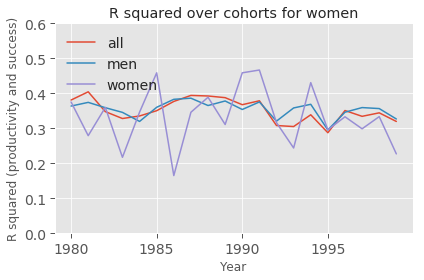

In [41]:
for group in ['all', 'men', 'women']:
    temp = results[results.group == group]
    plt.plot(temp['year'], temp['r_value'], label=group)
plt.xlabel("Year")
plt.ylabel("R squared (productivity and success)")
plt.title("R squared over cohorts for " + group)
plt.ylim((0,0.6))
plt.legend()
plt.show()

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


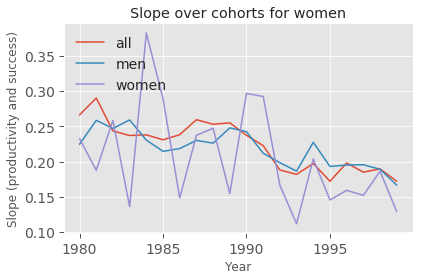

In [42]:
for group in ['all', 'men', 'women']:
    temp = results[results.group == group]
    plt.plot(temp['year'], temp['slope'], label=group)
plt.xlabel("Year")
plt.ylabel("Slope (productivity and success)")
plt.title("Slope over cohorts for " + group)
plt.legend()
plt.show()

In [43]:
results.head()

,year,num_obs,group,slope,intercept,r_value,p_value,std_err
0,1980,1191,all,0.266130,-0.549020,0.380942,1.995131e-42,0.018733
1,1980,700,men,0.224422,-0.492485,0.363733,2.545775e-23,0.021754
2,1980,92,women,0.232448,-0.485186,0.375356,2.270697e-04,0.060504
3,1981,1305,all,0.290055,-0.599003,0.404460,1.558603e-52,0.018170
4,1981,738,men,0.258454,-0.533874,0.374258,5.945793e-26,0.023605


In [44]:
credible_authors.reset_index(inplace=True)

In [45]:
# #print(credible_authors.head(n=1))
# credible_authors[credible_authors['author'] == 'donatella sciuto'].head(5)

# #print("-----------------------------------------")
# #print(authorPublicationData.head(n=1))

# authorPublicationData[authorPublicationData['author'] == 'donatella sciuto'].head(5)


temp = authorPublicationData.groupby(['year','author']).count().reset_index()
temp = temp.rename(columns={'pub_id':'num_pub'}, inplace=False)

# #print(temp[temp['author'] == 'donatella sciuto'].head(3))


authorPublicationData = temp.merge(credible_authors, how="inner", on=["author"])

# print(authorPublicationData[authorPublicationData['author'] == 'donatella sciuto'].head(3))

# authorPublicationData.shape



groupByYearData = calculate.groupDataAndCalculateCumulativeValues(authorPublicationData, 1, 'num_pub')

# #print(np.unique(groupByYearData['gender']))
authorPublicationData['gender'] = authorPublicationData['gender'].fillna('none')


years = groupByYearData['year'].unique()
years = sorted(years)

cohort_start_years = [y for y in years if y < (END_YEAR - MAX_CAREER_LENGTH_COHORT)]

# # here is a bug; total_num_pub of this author is 349; num_pub and cum_num_pub should only contain publications in "year"
# print(groupByYearData.head(n=1))
# print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(3))
# print(np.unique(groupByYearData["year"]))

In [46]:
from importlib import reload
reload(plot)

<module 'plot' from '/home/danielkostic/cumulative-advantage/plot.py'>

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


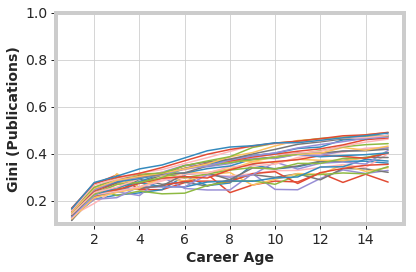

plot_cohort_size_gini_cor ---  unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


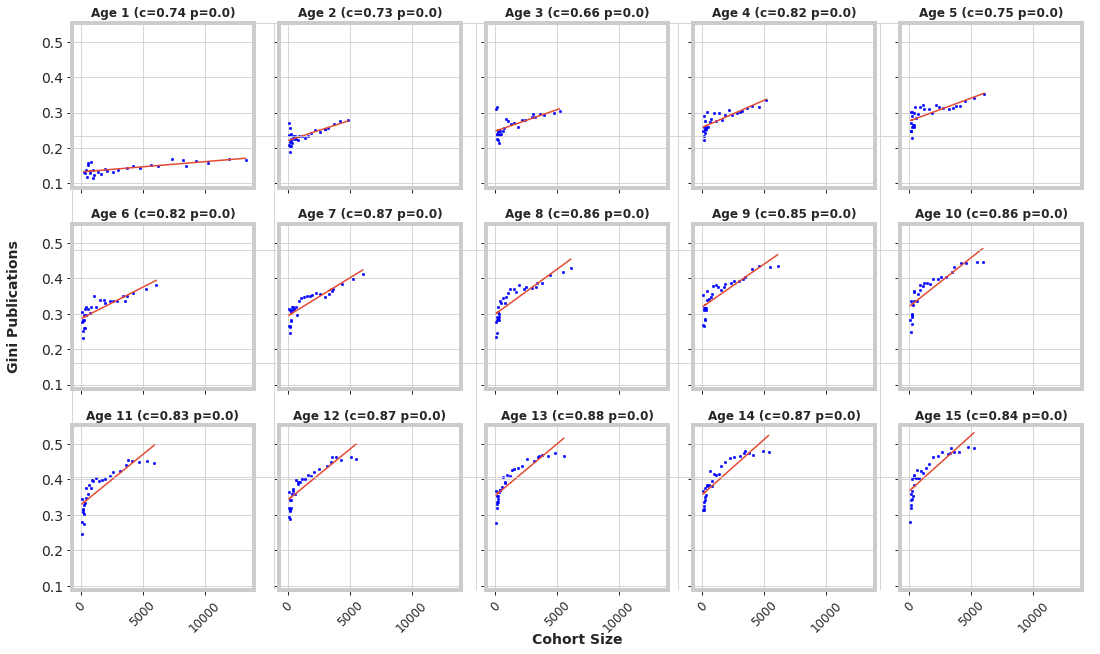

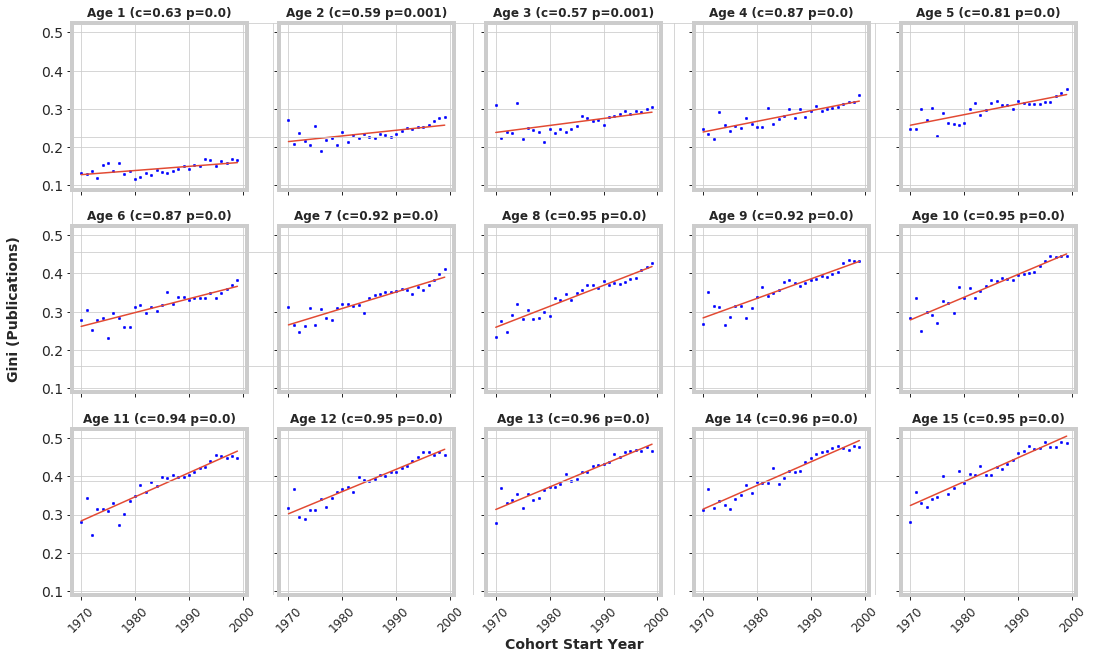

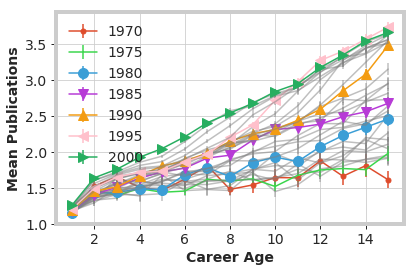

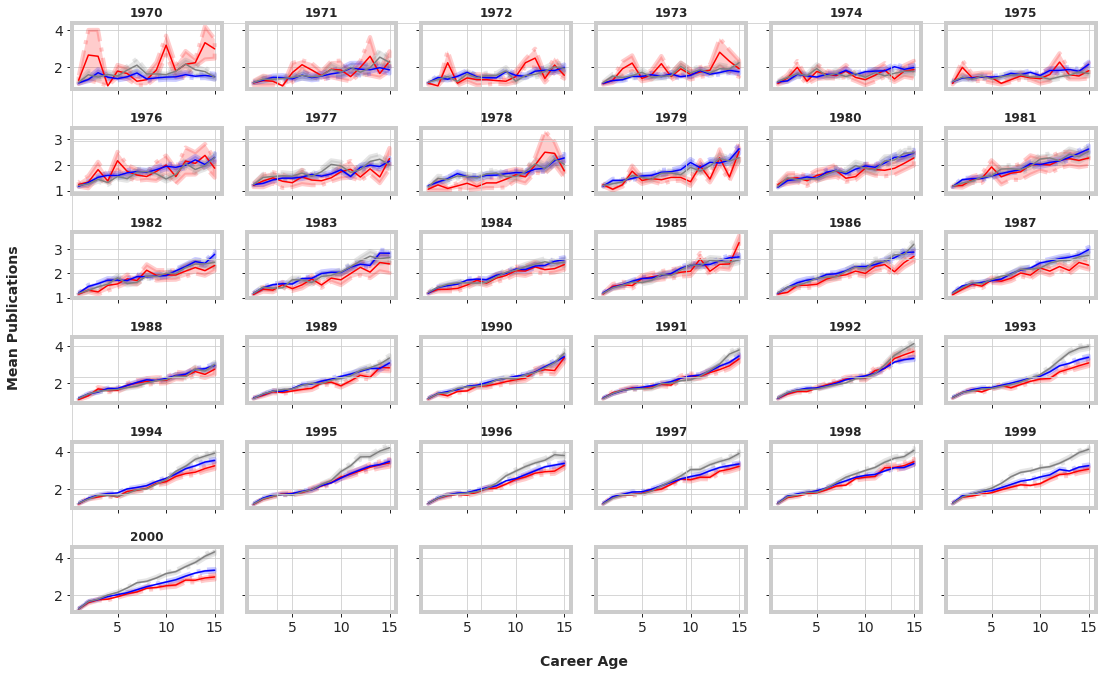

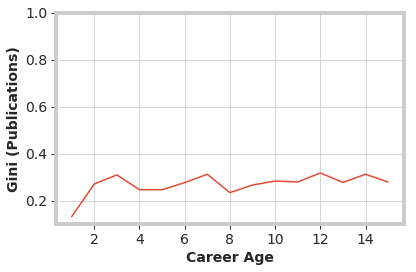

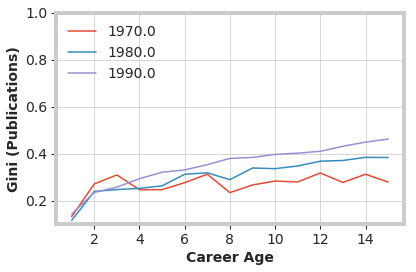

In [47]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_pub", "Publications")  

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


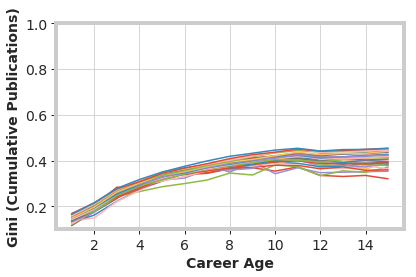

plot_cohort_size_gini_cor ---  unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


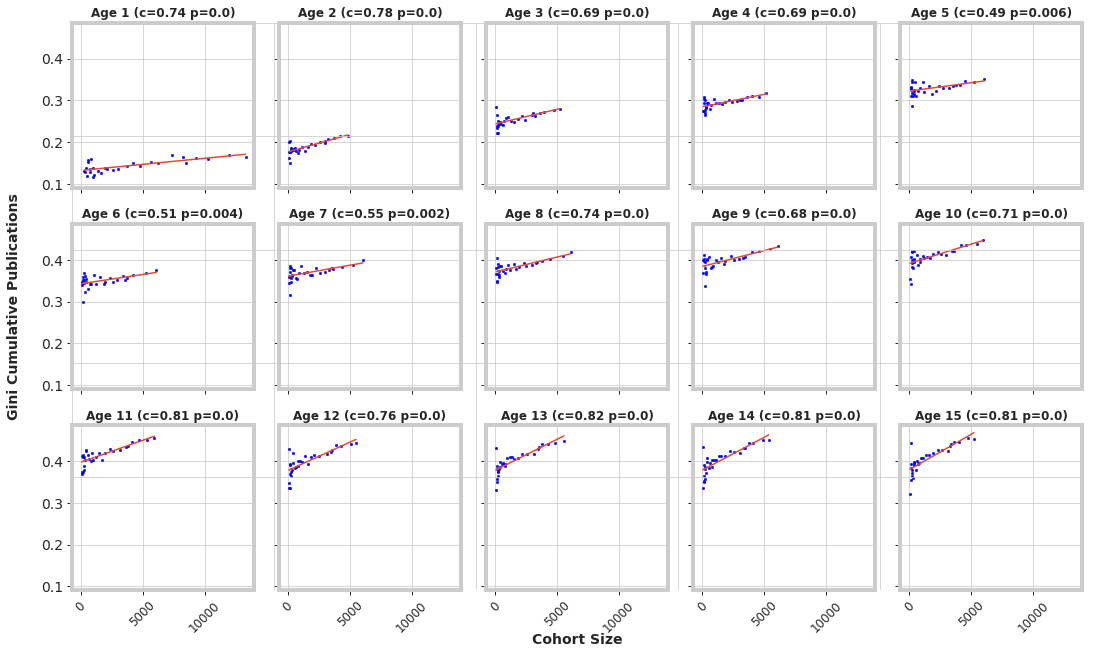

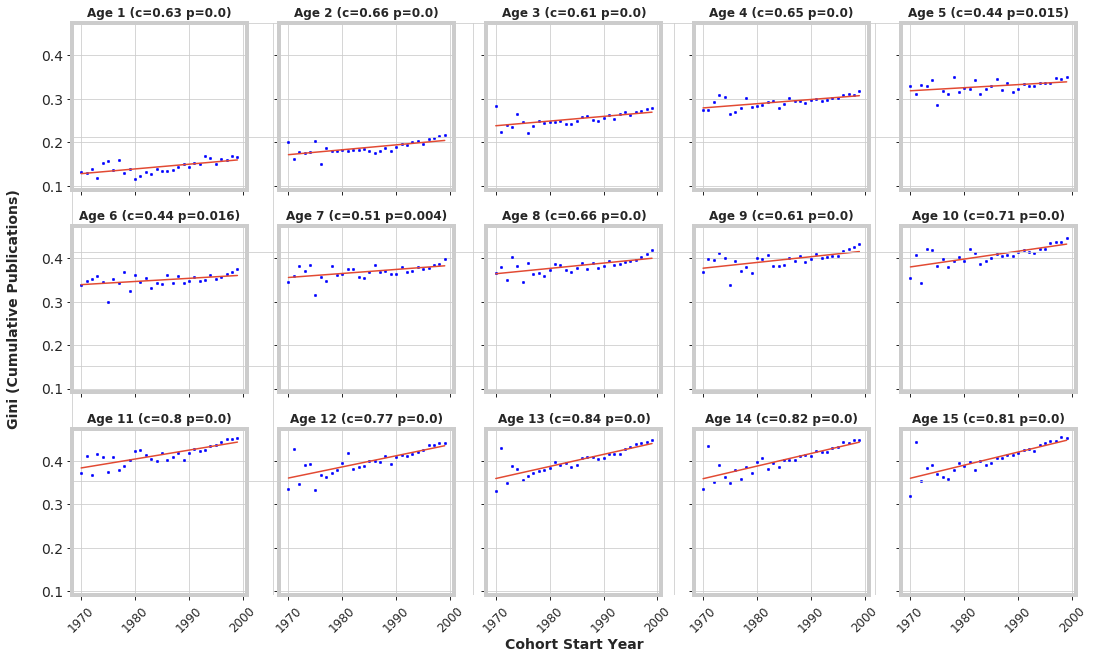

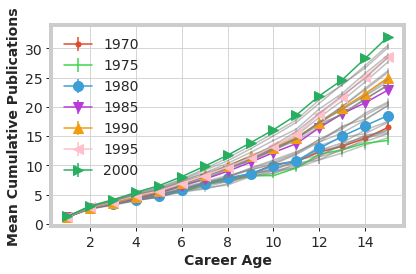

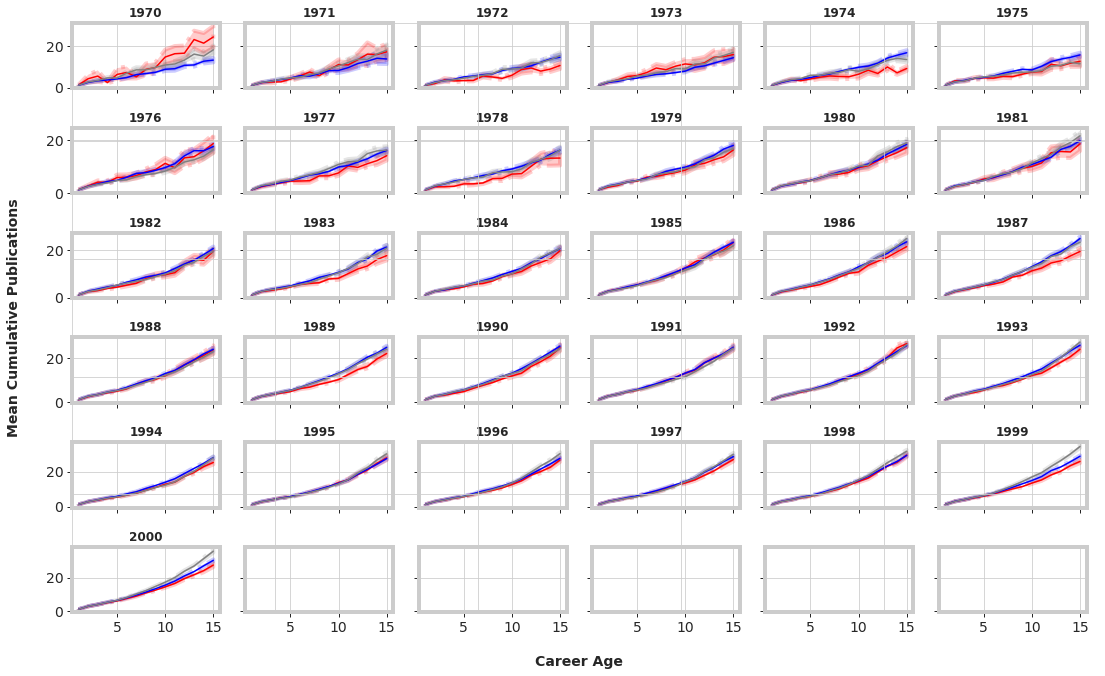

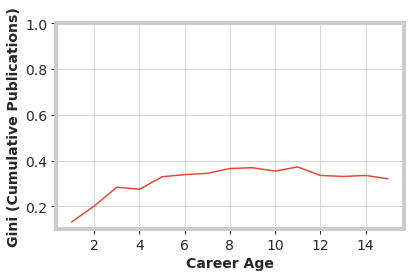

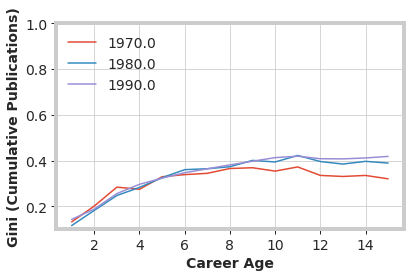

In [48]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "cum_num_pub", "Cumulative Publications")  